# Продвинутые Свёрточные Нейронные Сети. Часть 2. 
# Transfer Learning

## Переключение версии TensorFlow

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

## Загрузка датасета food101

In [2]:
(train_ds, test_ds), ds_info = tfds.load(
    'Food101', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'],
)

## Визуализация датасета food101

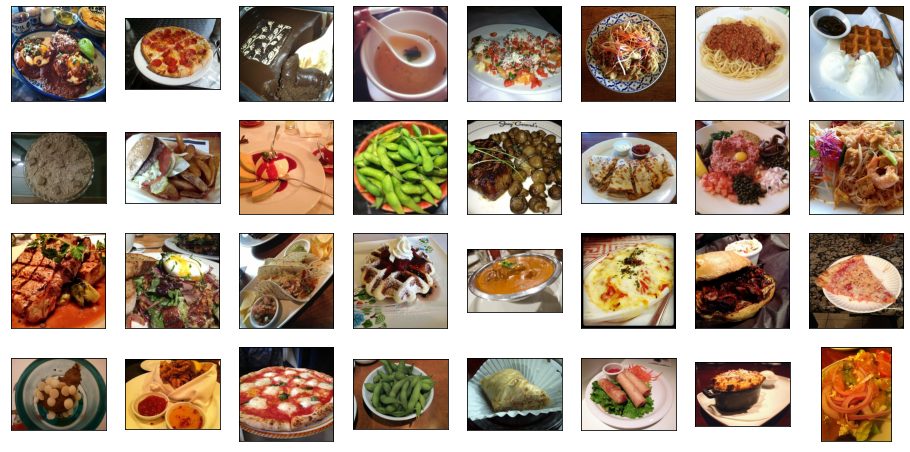

In [3]:
some_samples = [x[0] for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j])
    plt.xticks([]), plt.yticks([])
plt.show()

In [5]:
num_lables = 101

## Создание пайплайна данных с аугументацией

In [6]:
import random
INP_SIZE = 288
NUM_EPOCHS = 10
BATCH_SIZE = 128
a = []

#augumentation
def prepare(img, label):
    img = tf.cast(img, tf.float32)/255.
    if random.random() > 0.85:
        img = tf.image.flip_up_down(img)
    if random.random() > 0.8:
        img = tf.image.flip_left_right(img)
    if random.random() > 0.85:
        img = tf.image.random_brightness(img, 0.1)
    if random.random() > 0.85:
        img = tfa.image.rotate(
            img, 
            tf.random.uniform(()) * 10-5, 
            fill_mode='nearest'
        )    
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label


def prepare_test(img, label):
    img = tf.cast(img, tf.float32)/255.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label



train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare_test)
test_ds = test_ds.batch(128, drop_remainder=True)

# Подготовка модели CNN

In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3


EXP_NAME = 'transfer'
base_model = InceptionV3(
    include_top=False, 
    weights= 'imagenet', 
    input_shape=(INP_SIZE, INP_SIZE, 3)
)



base_model.trainable = False 

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(8096, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8096, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_lables, activation='softmax'),
])

In [8]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 288, 288, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 143, 143, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 143, 143, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 143, 143, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Подготовка к обучению

In [9]:
LEARNING_RATE = 0.00003
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits='True')

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/'+EXP_NAME, 
    write_graph=False, update_freq=100, profile_batch=0)

## Model Summary

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 7, 7, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 8096)              16588704  
_________________________________________________________________
batch_normalization_94 (Batc (None, 8096)              32384     
_________________________________________________________________
dropout (Dropout)            (None, 8096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8096)              65553312  
_________________________________________________________________
batch_normalization_95 (Batc (None, 8096)              3

## Обучение модели

In [11]:
%%time

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds,
    callbacks=[tensorboard_callback])

Epoch 1/10
532/532 [==============================] - 359s 657ms/step - loss: 3.0638 - accuracy: 0.3510 - val_loss: 1.8915 - val_accuracy: 0.5289
Epoch 2/10
532/532 [==============================] - 341s 641ms/step - loss: 2.2475 - accuracy: 0.4847 - val_loss: 1.8325 - val_accuracy: 0.5483
Epoch 3/10
532/532 [==============================] - 338s 634ms/step - loss: 1.9612 - accuracy: 0.5315 - val_loss: 1.7704 - val_accuracy: 0.5675
Epoch 4/10
532/532 [==============================] - 337s 633ms/step - loss: 1.7720 - accuracy: 0.5637 - val_loss: 1.7506 - val_accuracy: 0.5755
Epoch 5/10
532/532 [==============================] - 340s 638ms/step - loss: 1.6168 - accuracy: 0.5895 - val_loss: 1.7482 - val_accuracy: 0.5764
Epoch 6/10
532/532 [==============================] - 334s 627ms/step - loss: 1.4890 - accuracy: 0.6136 - val_loss: 1.7353 - val_accuracy: 0.5843
Epoch 7/10
532/532 [==============================] - 337s 633ms/step - loss: 1.3743 - accuracy: 0.6359 - val_loss: 1.7352 -

## Оценка качества модели

In [12]:
%%time

model.evaluate(test_ds)

59/59 [==============================] - 32s 534ms/step - loss: 1.7706 - accuracy: 0.5910
Wall time: 32.1 s


[1.7706187963485718, 0.5909692645072937]